# Uncertainty and sensitivity analysis

## Monte Carlo uncertainty analysis

### Model objects

BioSTEAM streamlines uncertainty analysis with an object-oriented framework where a [Model](../evaluation/Model.txt) object samples from parameter distributions and reevaluates biorefinery metrics at each new condition. In essence, a Model object sets parameter values, simulates the biorefinery system, and evaluates metrics across an array of samples.

![Simple Model](Model_Simple_UML.png "Model Simple UML")

Model objects are able to cut down simulation time by sorting the samples to minimize perturbations to the system between simulations. This decreases the number of iterations required to solve recycle systems. The following examples show how Model objects can be used.


### Create parameter distributions

**Let's first learn how to create common parameter distributions using** [chaospy](https://chaospy.readthedocs.io/en/master/tutorial.html).

A triangular distribution is typically used when the parameter is uncertain within given limits, but is heuristically known to take a particular value. Create a triangular distribution:

In [1]:
from chaospy import distributions as shape
lower_bound = 0
most_probable = 0.5
upper_bound = 1
triang = shape.Triangle(lower_bound, most_probable, upper_bound)
print(triang)

Triangle(0, 0.5, 1)


A uniform distribution is used when the theoretical limits of the parameter is known, but no information is available to discern which values are more probable. Create a uniform distribution:

In [2]:
from chaospy import distributions as shape
lower_bound = 0
upper_bound = 1
unif = shape.Uniform(lower_bound, upper_bound)
print(unif)

Uniform()


A large set of distributions are available through chaospy, but generally triangular and uniform distributions are the most widely used to describe the uncertainty of parameters in Monte Carlo analyses.

### Parameter objects

**Parameter objects are simply structures BioSTEAM uses to manage parameter values and distributions.**

This section is just to get you familiar with Parameter objects. All the fields that a Parameter object can have are described below. Don't worry if you don't fully understand what each field does. The main idea is that we need to define the `setter` function that the Parameter object uses to set the parameter value to the `element` (e.g. unit operation, stream, etc.) it pertains to. We can also pass a `distribution` (i.e. a chaospy distribution) that will be accessible for Model objects to sample from. As for the `name`, `units` of measure, and the `baseline` value, these are all for bookkeeping purposes. BioSTEAM incorporates the `name` and `units` of measure when creating a DataFrame of Monte Carlo results and parameter distributions. Parameter objects are created by Model objects which implicitly pass both the `system` affected by the parameter, and the `simulate` function. So don't worry about these last two fields, they are automatically added by the Model object when creating the parameter.

**simulate:** [function] Should simulate parameter effects.

**system:** [System] System associated to parameter.

**name:** [str] Name of parameter.

**units:** [str] Units of measure.

**baseline:** [float] Baseline value of parameter.

**element:** [object] Element associated to parameter.

**setter:** [function] Should set the parameter.

**distribution:** [chaospy.Dist] Parameter distribution.

Hopefully things will be become clearer as we start to create the parameter objects in the following sections...
    

### Create a model object

**Model objects are used to evaluate metrics around multiple parameters of a system.**

Create a Model object of the lipidcane biorefinery with internal rate of return and utility cost as metrics:

In [3]:
from biorefineries import lipidcane as lc
import biosteam as bst
solve_IRR = lc.lipidcane_tea.solve_IRR
total_utility_cost = lambda: lc.lipidcane_tea.utility_cost / 10**6 # In 10^6 USD/yr
metrics = (bst.Metric('Internal rate of return', lc.lipidcane_tea.solve_IRR, '%'),
           bst.Metric('Utility cost', total_utility_cost, '10^6 USD/yr'))
model = bst.Model(lc.lipidcane_sys, metrics)


C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:91: DesignWarning: vacuum pressure vessel ASME codes not implemented yet; wall thickness may be inaccurate and stiffening rings may be required
  warn('vacuum pressure vessel ASME codes not implemented yet; '
C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\_unit.py:613: RuntimeWarning: the purchase cost item, 'Vacuum system', has no defined bare-module factor in the 'SplitFlash.F_BM' dictionary; bare-module factor now has a default value of 1
  warn(warning)
C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:91: DesignWarning: vacuum pressure vessel ASME codes not implemented yet; wall thickness may be inaccurate and stiffening rings may be required
  warn('vacuum pressure vessel ASME codes not implemented yet; '
C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\_unit.py:613: RuntimeWarning: the purchase cost item, 'Vacuum system', has no defined bare-module factor in the 'Spl

The Model object begins with no parameters: 

In [4]:
model

Model: Biorefinery internal rate of return [%]
       Biorefinery utility cost [10^6 USD/yr]
 (No parameters)


### Add design parameters

**A design parameter is a Unit attribute that changes design requirements but does not affect mass and energy balances.**

Add number of fermentation reactors as a "design" parameter:

In [5]:
R301 = bst.main_flowsheet.unit.R301 # The Fermentation Unit
@model.parameter(name='Number of reactors',
                 element=R301, kind='design',
                 distribution=shape.Uniform(4, 10))
def set_N_reactors(N):
    R301.N = round(N)

The decorator uses the function to create a Parameter object and add it to the model:

In [6]:
parameters = model.get_parameters()
parameters

(<Parameter: [Fermentation-R301] Number of reactors>,)

Calling a Parameter object will update the parameter and results:

In [7]:
set_N_reactors_parameter = parameters[0]
set_N_reactors_parameter(5)
print(f'Puchase cost at 5 reactors: ${R301.purchase_cost:,.0f}')
set_N_reactors_parameter(8)
print(f'Puchase cost at 8 reactors: ${R301.purchase_cost:,.0f}')

Puchase cost at 5 reactors: $1,618,428
Puchase cost at 8 reactors: $1,912,811


The distribution will come into play later, when creating samples for Monte Carlo simulations.

### Add cost parameters

**A cost parameter is a Unit attribute that affects cost but does not change design requirements.**

Add the fermentation unit base cost as a "cost" parameter with a triangular distribution:

In [8]:
reactors_cost_coefficients = R301.cost_items['Reactors']
mid = reactors_cost_coefficients.n # Most probable at baseline value
lb = mid - 0.1 # Minimum
ub = mid + 0.1 # Maximum
@model.parameter(element=R301, kind='cost',
                 distribution=shape.Triangle(lb, mid, ub))
def set_exponential_cost_coefficient(exponential_cost_coefficient):
    reactors_cost_coefficients.n = exponential_cost_coefficient

Note that if the name was not defined, it defaults to the setter's signature:

In [9]:
model.get_parameters()

(<Parameter: [Fermentation-R301] Number of reactors>,
 <Parameter: [Fermentation-R301] Exponential cost coefficient>)

### Add isolated parameters

**An isolated parameter should not affect Unit objects in any way.**

Add feedstock price as a "isolated" parameter:

In [10]:
lipidcane = lc.lipidcane # The feedstock stream
lb = lipidcane.price * 0.9 # Minimum price
ub = lipidcane.price * 1.1 # Maximum price
@model.parameter(element=lipidcane, kind='isolated', units='USD/kg',
                 distribution=shape.Uniform(lb, ub))
def set_feed_price(feedstock_price):
    lipidcane.price = feedstock_price

### Add coupled parameters

**A coupled parameter affects mass and energy balances of the system.**

Add lipid fraction as a "coupled" parameter:

In [11]:
from biorefineries.lipidcane.utils import set_lipid_fraction
# Note that if the setter function is already made,
# you can pass it as the first argument
set_lipid_fraction = model.parameter(set_lipid_fraction,
                                     element=lipidcane, kind='coupled',
                                     distribution=shape.Uniform(0.05, 0.10))

Add fermentation efficiency as a "coupled" parameter:

In [12]:
@model.parameter(element=R301, kind='coupled',
                 distribution=shape.Triangle(0.85, 0.90, 0.95))
def set_fermentation_efficiency(efficiency):
    R301.efficiency = efficiency

### Evaluate metric given a sample

**The model can be called to evaluate a sample of parameters.**

Note that all parameters are stored in the model with highly coupled parameters first:

In [13]:
model

Model: Biorefinery internal rate of return [%]
       Biorefinery utility cost [10^6 USD/yr]
 Element:           Parameter:
 Stream-lipidcane   Lipid fraction
 Fermentation-R301  Efficiency
                    Number of reactors
                    Exponential cost coefficient
 Stream-lipidcane   Feedstock price


Get dictionary that contain DataFrame objects of parameter distributions:

In [14]:
df_dct = model.get_distribution_summary()
df_dct['Uniform']

,Element,Name,Units,Shape,lower,upper
0,Stream-lipidcane,Lipid fraction,,Uniform,0.05,0.1
1,Fermentation-R301,Number of reactors,,Uniform,4,10
2,Stream-lipidcane,Feedstock price,USD/kg,Uniform,0.0311,0.038


In [15]:
df_dct['Triangle']

,Element,Name,Units,Shape,lower,midpoint,upper
0,Fermentation-R301,Efficiency,,Triangle,0.85,0.9,0.95
1,Fermentation-R301,Exponential cost coefficient,,Triangle,0.4,0.5,0.6


Evaluate sample:

In [16]:
model([0.05, 0.85, 8, 100000, 0.040]) # Returns metrics (IRR and utility cost)

C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:91: DesignWarning: vacuum pressure vessel ASME codes not implemented yet; wall thickness may be inaccurate and stiffening rings may be required
  warn('vacuum pressure vessel ASME codes not implemented yet; '


Biorefinery  Internal rate of return [%]   0.135
             Utility cost [10^6 USD/yr]    -27.8
dtype: float64

### Monte Carlo

Sample from a joint distribution, and simulate samples:

In [17]:
import numpy as np
np.random.seed(1234) # For consistent results
N_samples = 50
rule = 'L' # For Latin-Hypercube sampling
samples = model.sample(N_samples, rule)
model.load_samples(samples)
model.evaluate()
model.table # All evaluations are stored as a pandas DataFrame

C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\solids_separation.py:147: DesignWarning: <SolidsCentrifuge: C301> Solids loading (1.975 ton/hr) is out of bounds (minimum 2 ton/hr).
  lb_warning(self, 'Solids loading', ts, 'ton/hr', lb)
C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:82: CostWarning: <Flash: First evaporator> Vertical vessel length (54.5 ft) is out of bounds (12 to 40 ft).
  return method(pressure, diameter, length)
C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:82: CostWarning: <Flash: First evaporator> Vertical vessel length (53.5 ft) is out of bounds (12 to 40 ft).
  return method(pressure, diameter, length)
C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:82: CostWarning: <Flash: First evaporator> Vertical vessel length (52.5 ft) is out of bounds (12 to 40 ft).
  return method(pressure, diameter, length)
C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\

Element  Stream-lipidcane Fermentation-R301                     \
Variable   Lipid fraction        Efficiency Number of reactors   
0                  0.0912             0.878               4.69   
1                  0.0716             0.932                  6   
2                  0.0574             0.918                7.7   
3                  0.0778              0.87               9.71   
4                  0.0678             0.878               9.88   
..                    ...               ...                ...   
45                 0.0835             0.891               8.48   
46                  0.085             0.892               9.49   
47                 0.0526             0.896                9.9   
48                 0.0763              0.94               8.75   
49                 0.0945             0.916               4.39   

Element                                       Stream-lipidcane  \
Variable Exponential cost coefficient Feedstock price [USD/kg]   
0                               0.508                   0.0362   
1                               0.468                   0.0354   
2                               0.513                   0.0359   
3                               0.561                   0.0348   
4                               0.495                   0.0334   
..                                ...                      ...   
45                              0.423                   0.0335   
46                              0.549                   0.0321   
47                              0.511                   0.0367   
48                               0.52                   0.0376   
49                              0.506                   0.0314   

Element                  Biorefinery                             
Variable Internal rate of return [%] Utility cost [10^6 USD/yr]  
0                              0.191                        -33  
1                              0.187                      -30.1  
2                              0.172                      -28.4  
3                              0.185                      -31.3  
4                              0.184                        -30  
..                               ...                        ...  
45                             0.197                        -32  
46                             0.205                      -32.2  
47                             0.159                      -27.8  
48                             0.181                      -30.7  
49                             0.218                      -33.3  

[50 rows x 7 columns]

Note that coupled parameters are on the left most columns, and are ordered from upstream to downstream (e.g. <Stream: Lipid cane> is upstream from <Fermentation: R301>)

## Sensitivity with Spearman's rank order correlation

Model objects also presents methods for sensitivity analysis such as Spearman's correlation, a measure of monotonicity between variables:

In [18]:
df_rho, df_p = model.spearman_r()
df_rho['Biorefinery', 'Internal rate of return [%]']

Element            Parameter                   
Stream-lipidcane   Lipid fraction                  0.845
Fermentation-R301  Efficiency                     0.0271
                   Number of reactors             -0.151
                   Exponential cost coefficient   -0.068
Stream-lipidcane   Feedstock price [USD/kg]       -0.594
Name: (Biorefinery, Internal rate of return [%]), dtype: float64

Create a tornado plot of Spearman's correlation between all parameters and IRR:

(<Figure size 432x288 with 3 Axes>,
 <AxesSubplot:xlabel="Spearman's correlation with IRR [%]">)

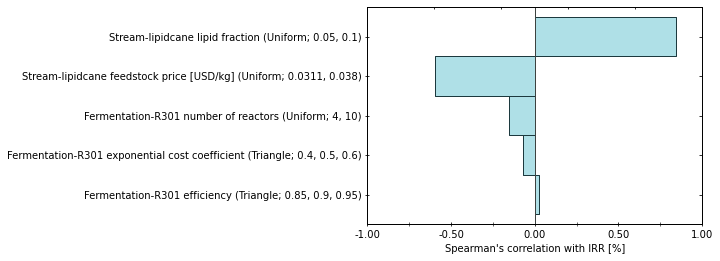

In [19]:
bst.plots.plot_spearman_1d(df_rho['Biorefinery', 'Internal rate of return [%]'], 
                           index=[i.describe() for i in model.parameters],
                           name='IRR [%]')

## Single point sensitivity

A quick way to evaluate sentivity is through single point sensitivity analysis, whereby a metric is evaluated at the baseline and at the lower and upper limits of each parameter. This method ignores the interactions between parameters and their distributions, but can help screen whether a system is sensitive to a given parameter. Model objects also facilitate this analysis:

In [20]:
baseline, lower, upper = model.single_point_sensitivity()
print('BASELINE')
print('--------')
print(baseline)
print()
print('LOWER')
print('-----')
print(lower)
print()
print('UPPER')
print('-----')
print(upper)

C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:91: DesignWarning: vacuum pressure vessel ASME codes not implemented yet; wall thickness may be inaccurate and stiffening rings may be required
  warn('vacuum pressure vessel ASME codes not implemented yet; '
C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:82: CostWarning: <Flash: First evaporator> Vertical vessel length (52.5 ft) is out of bounds (12 to 40 ft).
  return method(pressure, diameter, length)
C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:82: CostWarning: <Flash: First evaporator> Vertical vessel length (46.5 ft) is out of bounds (12 to 40 ft).
  return method(pressure, diameter, length)
C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\solids_separation.py:147: DesignWarning: <SolidsCentrifuge: C301> Solids loading (1.414 ton/hr) is out of bounds (minimum 2 ton/hr).
  lb_warning(self, 'Solids loading', ts, 'ton/hr',

BASELINE
--------
Element      Variable                   
Biorefinery  Internal rate of return [%]   0.188
             Utility cost [10^6 USD/yr]    -30.8
dtype: float64

LOWER
-----
Element                                                        Biorefinery  \
Variable                                       Internal rate of return [%]   
Element           Variable                                                   
Stream-lipidcane  Lipid fraction                                     0.169   
Fermentation-R301 Efficiency                                         0.181   
                  Number of reactors                                 0.189   
                  Exponential cost coefficient                       0.187   
Stream-lipidcane  Feedstock price [USD/kg]                           0.203   

Element                                                                    
Variable                                       Utility cost [10^6 USD/yr]  
Element           Variable            

Create a tornado plot of the lower and upper values of the IRR:

(<Figure size 432x288 with 3 Axes>, <AxesSubplot:xlabel='IRR [%]'>)

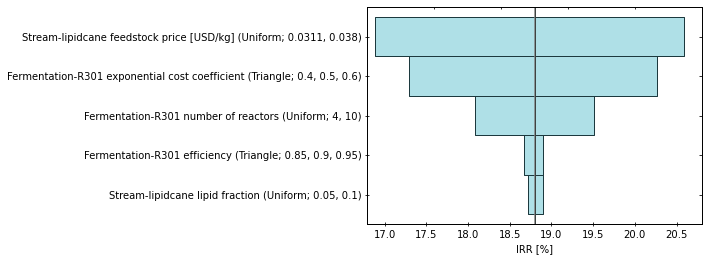

In [21]:
IRR, utility_cost = model.metrics
metric_index = IRR.index
index = [i.describe() for i in model.parameters]
bst.plots.plot_single_point_sensitivity(100 * baseline[metric_index],
                                        100 * lower[metric_index], 
                                        100 * upper[metric_index],
                                        name='IRR [%]',
                                        index=index)